In [19]:
import matplotlib
import numpy as np
from src.main.flags_global import FLAGS
FLAGS.mark_as_parsed()
from src.main.RecognizeElevatorElements import RecognizeElevatorElements
from src.models.research.object_detection.utils import label_map_util
from absl import logging

In [3]:
label_map_path = FLAGS.label_map_path_detection
category_index_detection = label_map_util.create_category_index_from_labelmap(label_map_path, use_display_name=True)
application = RecognizeElevatorElements()

In [4]:
def get_next_input_batch():
    input_data = application.input.get_input_data_batch()
    if input_data is None:
        logging.warning('No InputData. Skipping.')
        return
    return input_data

def next_image_detection(input_image):
    return application.detection.detect_next_image(input_image)

def nms_detection(detections):
    return application.processing.filter_by_nms(detections)

def filter_only_floor_buttons(detections_nms):
    return application.processing.filter_one_category(detections_nms, category='btn_floor')

from src.utils.image_utils import crop_multiple_images_by_bndbox
def crop_by_bndbox(input_image, detections_to_crop):
    return crop_multiple_images_by_bndbox(input_image, detections_to_crop)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def classify_buttons(detection_buttons_roi):
    button_classifications = []
    for button_roi in detection_buttons_roi:
        button_roi_tensor = tf.convert_to_tensor(np.expand_dims(button_roi, 0), dtype=tf.float32)
        button_roi_tensor_resized = tf.image.resize_with_pad(button_roi_tensor, 224, 224, method=tf.image.ResizeMethod.BICUBIC)
        button_classification = application.classification.classify_next_tensor(button_roi_tensor_resized)
        button_classifications.append(button_classification)
    return button_classifications

def sort_button_scores_and_assign_labels(button_classifications, labels):
    predictions_sorted = []
    for entry in button_classifications:
        prediction = entry[0]
        scores_sorted, labels_sorted = application.processing.get_classification_label(prediction, labels)
        predictions_sorted.append({'class_prediction': labels_sorted, 'class_score': scores_sorted})
    return predictions_sorted

def create_category_index_from_list(classname_list):
    category_index = {}
    index = 1
    for classname in classname_list:
        category_index[index] = {'id': index, 'name': str(classname)}
        index += 1
    return category_index



In [86]:
input_data = get_next_input_batch()

In [79]:
detections = next_image_detection(input_data['ImageData'])
detections_nms = nms_detection(detections)
detection_buttons = filter_only_floor_buttons(detections_nms)

In [80]:
detection_buttons_roi = crop_by_bndbox(input_data['ImageData'], detection_buttons['detection_boxes_nms'])
button_classifications = classify_buttons(detection_buttons_roi)

In [81]:
labels = [-2, -1, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 3, 4, 5, 6, 7, 8, 9]
category_index_classification = create_category_index_from_list(labels)
button_classifications_sorted = sort_button_scores_and_assign_labels(button_classifications, labels)
button_bndboxes = detection_buttons['detection_boxes_nms']
button_classes = []
button_scores = []
for button in button_classifications:
    class_index = np.argmax(button[0], axis=0)
    button_classes.append(class_index)
    button_scores.append(button[0][class_index])

In [82]:
image_with_detections = input_data['ImageData'].copy()
from src.models.research.object_detection.utils import visualization_utils as viz_utils
if detections_nms['detection_classes_nms'].shape != 0:
    viz_utils.visualize_boxes_and_labels_on_image_array(image_with_detections,
                                                        detections_nms['detection_boxes_nms'],
                                                        detections_nms['detection_classes_nms'].astype(int),
                                                        detections_nms['detection_scores_nms'],
                                                        category_index_detection,
                                                        use_normalized_coordinates=True,
                                                        line_thickness=1,
                                                        max_boxes_to_draw=50,
                                                        min_score_thresh=.20,
                                                        agnostic_mode=False)

In [83]:
label_id_offset = 1
button_classes = [x+label_id_offset for x in button_classes]
image_with_button_classification = input_data['ImageData'].copy()
if detection_buttons['detection_classes_nms'].shape != 0:
    viz_utils.visualize_boxes_and_labels_on_image_array(image_with_button_classification,
                                                        button_bndboxes,
                                                        button_classes,
                                                        button_scores,
                                                        category_index_classification,
                                                        use_normalized_coordinates=True,
                                                        max_boxes_to_draw=25,
                                                        min_score_thresh=.00,
                                                        agnostic_mode=False)

In [87]:
%matplotlib auto
matplotlib.pyplot.imshow(image_with_detections)
matplotlib.pyplot.savefig(r"C:\Users\cernil\Documents\test_floor_classification_output\detection.png", dpi=300)
matplotlib.pyplot.show()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>

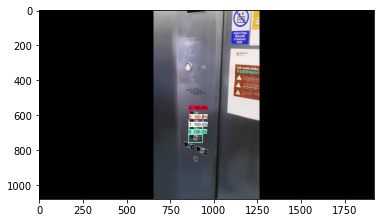

In [85]:
%matplotlib auto
matplotlib.pyplot.imshow(image_with_button_classification)
matplotlib.pyplot.savefig(r"C:\Users\cernil\Documents\test_floor_classification_output\classification.png", dpi=300)
matplotlib.pyplot.show()

In [88]:
import cv2
cv2.imshow('ImageDetections', image_with_detections)
cv2.imshow('FloorClassification', image_with_button_classification)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1